# REINFORCEMENT LEARNING

### Author: Hyungjoo Kim

##### All data was provided by University College London, Department of Computer Science, Reinforcement Learning Module

##### Supervisor: Prof. Hado Van Hasselt, Matteo Hessel, and Diana Borsa

**Context**

In this assignment, we will take a first look at learning algorithms for sequential decision problems.

**Background reading**

* Sutton and Barto (2018), Chapters 3 - 6

**Overview of this assignment**

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [1]:
import matplotlib.collections as mcoll
import matplotlib.path as mpa
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [2]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-colorblind')

### Some grid worlds

In [3]:
W = -100  # wall
G = 100  # goal

GRID_LAYOUT = np.array([
  [W, W, W, W, W, W, W, W, W, W, W, W],
  [W, W, 0, W, W, W, W, W, W, 0, W, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, G, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, W, W, W, W, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, W],
  [W, W, 0, 0, 0, 0, 0, 0, 0, 0, W, W],
  [W, W, W, W, W, W, W, W, W, W, W, W]
])

class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = GRID_LAYOUT
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(self, obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state
    
    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    reward = self._layout[new_y, new_x]
    if self._layout[new_y, new_x] == W:  # wall
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = -1.
      discount = 0.9
    else:  # a goal
      discount = 0.
      new_state = self._start_state

    if self._noisy:
      width = self._layout.shape[1]
      reward += 10*np.random.normal(0, width - new_x + new_y)

    self._state = new_state
    return reward, discount, self.get_obs()

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout != W, interpolation="nearest", cmap='pink')
    plt.gca().grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(9, 2, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

In [4]:
SMALL_GRID_LAYOUT = np.array([
  [W, W, W, W, W],
  [W, W, 3, W, W],
  [W, W, 0, W, W],
  [W, 1, 0, W, W],
  [W, W, 0, W, W],
  [W, W, 0, 4, W],
  [W, W, W, W, W]
])


def plot_small_grid(version=1):
  plt.imshow(SMALL_GRID_LAYOUT < -1, interpolation='nearest', cmap='pink_r',
             vmin=-0.2, vmax=1.2)
  if version == 1:
    plt.text(2, 1, '$+3$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+4$', ha='center', va='center', fontsize=12)
  else:
    plt.text(2, 1, '$+2$', ha='center', va='center', fontsize=12)
    plt.text(1, 3, '$+1$', ha='center', va='center', fontsize=12)
    plt.text(3, 5, '$+5$', ha='center', va='center', fontsize=12)
  plt.text(2, 3, '$S$', ha='center', va='center', fontsize=12)
  h, w = SMALL_GRID_LAYOUT.shape
  for r in np.arange(0.5, h):
    plt.plot([-0.5, w - 0.5], [r, r], '-k', lw=3, alpha=0.4)
  for c in np.arange(0.5, w):
    plt.plot([c, c], [-0.5, h - 0.5], '-k', lw=3, alpha=0.4)
  plt.xticks([]); plt.yticks([]);

### Helper functions
(You should not have to change, or even look at, these.  Do run the cell to make sure the functions are loaded though.)

In [10]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += reward
    return mean_reward/float(number_of_steps)

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(grid, values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values - 1000*(grid<0), interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

# Implementing algorithms

**Minimal agent interface**:

Each agent should implement the following methods:

### `__init__(self, number_of_actions, number_of_states, initial_observation, ...)`:
The constructor will provide the agent the number of actions, number of states, and the initial state. You can get the initial state by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`. The constructor may accept additional arguments (denoted here by the ellipsis `...`) depending on the specific algorithm implemented by the agent.

### `step(self, reward, discount, next_state)`:

The step method of an agent should update its internals, in whatever way is appropriate for its learning algorithm, and return a new action to be executed in the environment.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_state` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_state})$" in the update, because $\gamma = 0$ (for whatever definition of $v$ is appropriate---for instance, $v(s)$ could be defined in terms of action values estimates that we are learning, for instance by $v(s) = \max_a q(s, a)$).  Therefore, the end of an episode can be seamlessly handled with the same step function.

**Note on the initial action**:

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state and reward.  In the constructor (`__init__`), make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```
In our experiments the helper functions above will execute the action `0` (which corresponds to `up` in the grid world) as the initial action to begin the run loop of the experiment.  This initial action is only executed once, and the beginning of the very first episode---not at the beginning of each episode.

### A random agent

Below we show a reference implementation of a simple random agent, implemented according to the interface above.

In [11]:
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### The grid

The cell below shows the `Grid` environment that we will use in this section. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-100` for bumping into a wall, `+100` for reaching the goal, and `-1` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

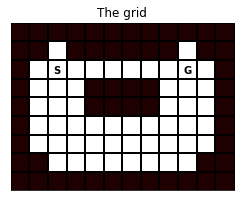

In [12]:
grid = Grid()
grid.plot_grid()


## Task 1 - Implement TD Learning
Implement an agent that acts randomly, and _on-policy_ estimates state values $v(s)$, using one-step TD learning with step size $\alpha=0.1$.

In addition to the base interface, also implement a property `state_values(self)` returning the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement the `step` function.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  

**Hint**: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.

In [15]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  @property
  def state_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    ''' Reference = Lecture 5: Model-Free Prediction page 28'''
    # self._values[self._state] = q(s, a), which is state-action value function
    self._values[self._state] = self._values[self._state] + self._step_size * (reward + discount * (self._values[next_state]) - self._values[self._state])
    self._state = next_state  # update new state as the next state
    
    # This system implement randomly, so it's a random TD learning
    next_action = np.random.randint(self._number_of_actions)
    return next_action

### Run the next cell to run the `RandomTD` agent on a grid world.

If everything worked as expected, the plot below will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange below).

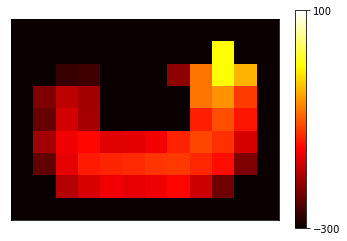

In [18]:
# Do not modify this cell.
agent = RandomTD(grid._layout.size, 4, grid.get_obs())
run_experiment(grid, agent, int(1e5))
v = agent.state_values
plot_values(GRID_LAYOUT, v.reshape(grid._layout.shape), colormap="hot", vmin=-300, vmax=100)

## Task 2 - Policy iteration 
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model, so for each state and for each action we can look at the value of the resulting state, and would then pick the action with the highest reward plus subsequent state value. In other words, you can assume we can use $q(s, a) = \mathbb{E}[ R_{t+1} + \gamma v(S_{t+1}) \mid S_t = s, A_t = a]$, where $v$ is the value function learned by TD as implemented. Then we consider the policy that picks the action with the highest action value $q(s, a)$. You do **not** have to implement this, just answer the following question.

The above amounts to performing an iteration of policy evaluation and policy improvement.  If we repeat this process over and over again, and repeatedly evaluate the greedy policy and then perform an improvement step by picking the greedy policy, would the policy eventually become optimal?  Explain why or why not in at most three sentences.

> In the policy iteration of policy evaluation and improvement situation, there is a possibility that the greedy policy can continue to select an action if the average reward gradually increases but not significantly. This is because the agent does not properly recognise the value of the reward where it is a higher reward in some cases. Therefore, the greedy policy does not take into account exploration so that the policy is eventually not optimal.